## Introduction

In this project, we study efficient exploration of univariate Gaussian mixture posteriors. The multimodality of mixture posteriors make them hard to sample with standard MCMC methods, as the chain often gets stuck at a particular mode. Essentially, we'll present a new strategy based on free-energy methods in statistical physics that finds a related distribution which is significantly less multimodal and easier to sample from. Then, we sample from this new distribution and use standard importance sampling to retrieve the original distribution. In this project, we will briefly introduce the idea behind this method, implement it, and compare its performance with the standard Metropolis Hastings Algorithm.

## Preliminaries

In this project, we focus on the univariate Gaussian mixture model with the following likelihood:
$$p(y, \theta) = \prod_{i = 1}^np(y_i \mid \theta), \:\:p(y_i \mid \theta) = \sum_{k = 1}^Kq_k\varphi(y_i; \mu_k, \lambda_k^{-1}),$$
where the vector $\theta$ contains all the unknown parameters, $i.e.$ the mixture weights $q_1, \ldots, q_{K - 1}$, the means $\mu_1, \ldots, \mu_K$ and the precisions $\lambda_1, \ldots, \lambda_K$; and $\varphi(\cdot; \mu, \lambda^{-1})$ denotes the Gaussian density with mean $\mu$ and variance $\lambda^{-1}$. Note that since any local mode of the posterior density admits $K! - 1$ symmetric replicates, there are at least $K!$ modes, while a typical MCMC sampler could recover only one of them.

The parameters are associated with the following prior, which is symmetric with respect to the components $k = 1, \ldots, K$:
\begin{align*}\mu_k &\sim \mathcal{N}(m, \kappa^{-1}),\\
\lambda_k &\sim \text{Gamma}(\alpha, \beta),\\
\beta &\sim \text{Gamma}(g, h),\\
(q_1, \ldots, q_{K - 1}) &\sim \text{Dirichlet}_K(1, \ldots, 1).
\end{align*}

In our example, we take $m = M$, $\kappa = \frac{4}{R^2}$, $\alpha = 2$, $g = 0.2$, $h = \frac{100g}{\alpha R^2}$, where $R$ and $M$ are respectively the range and the mean of the observed data. Then, the posterior density is:
\begin{align*}p(\theta \mid y) &= \frac{1}{Z_k}p(\theta)p(y \mid \theta)\\
&= \frac{\kappa^{K / 2}g^h\beta^{K\alpha + g - 1}}{Z_K\Gamma(\alpha)^K\Gamma(g)(2\pi)^{\frac{n + K}{2}}}\left(\prod_{k = 1}^K\lambda_k\right)^{\alpha - 1}\exp\left\{-\frac{\kappa}{2}\sum_{k = 1}^K(\mu_k-M)^2 - \beta\left(h + \sum_{k = 1}^K\lambda_k\right)\right\}\\
& \quad\times\prod_{i = 1}^n\left[\sum_{k = 1}^Kq_k\lambda_k^{1/2}\exp\left\{-\frac{\lambda_k}{2}(y_i - \mu_k)^2\right\}\right].
\end{align*}

In this expression, $\theta$ is the vector
$$\theta = (q_1, \ldots, q_{K - 1}, \mu_1, \ldots, \mu_K, \lambda_1, \ldots, \lambda_K, \beta) \in \Omega = \mathcal{S}_K \times \mathbb{R}^K \times (\mathbb{R}^+)^{K + 1},$$
the set 
$$\mathcal{S}_K = \left\{(q_1, \ldots, q_{K - 1}) \in (\mathbb{R}^+)^{K - 1}, \sum_{i = 0}^{k - 1}q_i \leq 1\right\}$$
is the probability simplex, and
$$Z_K = \int_\Omega p(\theta)p(y \mid \theta)\text{d}\theta$$
is the normalizing constant. We will focus on the sampling this posterior distribution.

## Implementation of Metropolis Hastings Algorithm

In this section, we implement the standard Metropolis Hastings algorithm and see how it performs on exploring this multimodal posterior.

We consider the Fishery data of Titterington et al., which consists of 256 snappers, and a Gaussian mixture model with $K = 3$ components; see below for a histogram.

6.103515625


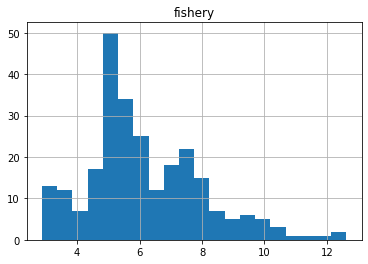

In [10]:
import numpy as np
import pandas as pd
import statistics as st

fishery =  [2.875, 2.875, 2.875, 2.875, 2.875, 2.875, 3.125, 3.125, 3.125, 3.125, 3.125,
3.125, 3.125, 3.375, 3.375, 3.375, 3.375, 3.375, 3.375, 3.375, 3.375, 3.375,
3.625, 3.625, 3.625, 3.875, 3.875, 3.875, 4.125, 4.125, 4.125, 4.125, 4.375,
4.375, 4.375, 4.375, 4.375, 4.375, 4.625, 4.625, 4.625, 4.625, 4.625, 4.625,
4.625, 4.625, 4.625, 4.625, 4.625, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 
4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875,
4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 4.875, 5.125, 5.125, 
5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125,
5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125, 5.125,
5.375, 5.375, 5.375, 5.375, 5.375, 5.375, 5.375, 5.375, 5.375, 5.375, 5.375,
5.375, 5.375, 5.375, 5.375, 5.375, 5.375, 5.625, 5.625, 5.625, 5.625, 5.625,
5.625, 5.625, 5.625, 5.625, 5.625, 5.625, 5.625, 5.625, 5.625, 5.625, 5.625,
5.625, 5.875, 5.875, 5.875, 5.875, 5.875, 5.875, 5.875, 5.875, 5.875, 5.875,
5.875, 5.875, 5.875, 5.875, 6.125, 6.125, 6.125, 6.125, 6.125, 6.125, 6.125,
6.125, 6.125, 6.125, 6.125, 6.375, 6.375, 6.375, 6.375, 6.375, 6.375, 6.375,
6.375, 6.625, 6.625, 6.625, 6.625, 6.875, 6.875, 6.875, 6.875, 6.875, 6.875,
6.875, 7.125, 7.125, 7.125, 7.125, 7.125, 7.125, 7.125, 7.125, 7.125, 7.125,
7.125, 7.375, 7.375, 7.375, 7.375, 7.375, 7.375, 7.375, 7.375, 7.375, 7.375,
7.375, 7.625, 7.625, 7.625, 7.625, 7.625, 7.625, 7.625, 7.625, 7.625, 7.625,
7.625, 7.875, 7.875, 7.875, 7.875, 7.875, 7.875, 7.875, 7.875, 7.875, 8.125,
8.125, 8.125, 8.125, 8.125, 8.125, 8.375, 8.375, 8.375, 8.375, 8.625, 8.625,
8.625, 8.875, 8.875, 8.875, 9.125, 9.125, 9.375, 9.375, 9.625, 9.625, 9.625,
9.625, 9.875, 9.875, 9.875, 10.125, 10.125, 10.375, 10.375, 10.625, 10.875, 11.375,
11.875, 12.375, 12.625]

fish = pd.DataFrame(data = fishery, columns = ["fishery"])
fish.hist(bins = 20)
print(st.mean(fishery))

Then, we implement the Metropolis Hasting algorithm with normal random walk and plot the trajectories of $(\mu_1, \mu_2, \mu_3)$ and $\beta$ for $10^8$ iterations. In this example, $M = m = 6.1035$, $R = 9.75$, $\kappa = 0.042$, $\alpha = 2$, $g = 0.2$, $h = 0.1052$.

0.36333333333333334
0.6524583333333334
0.546375
0.616875


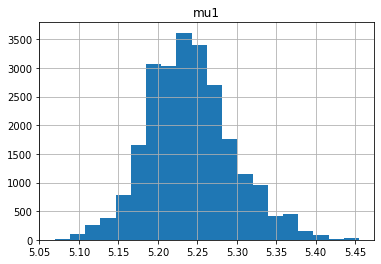

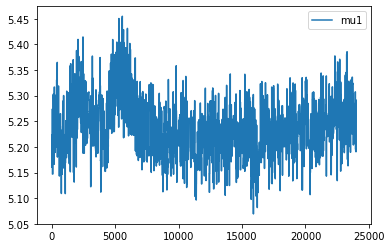

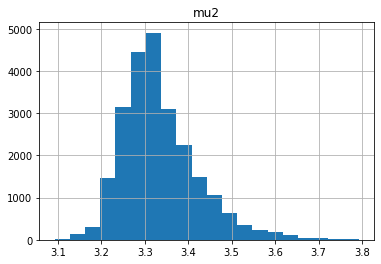

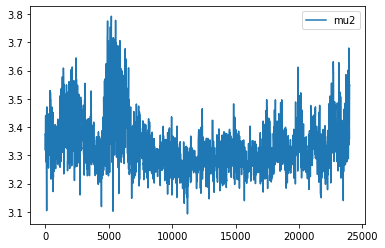

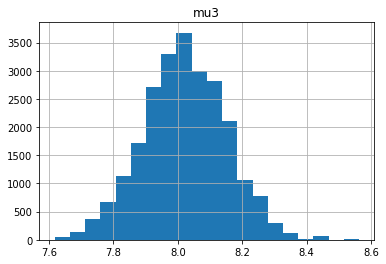

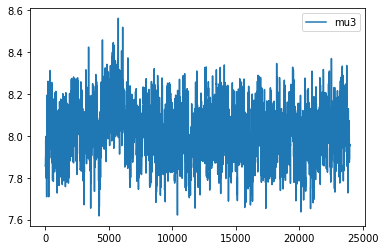

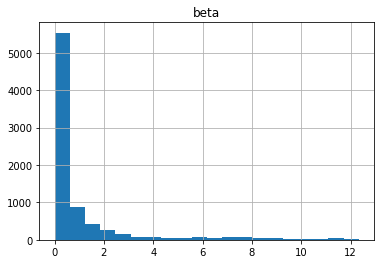

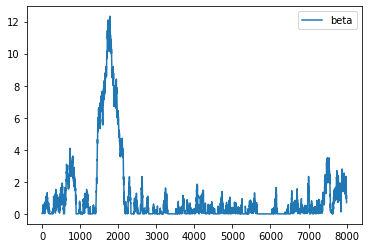

In [16]:
m = 6.1035; R = 9.75; kappa = 0.042
alpha = 2; g = 0.2; h = 0.1052
y = fishery

#return log density of gamma(alpha, beta)
def lgamma_lbda(lbda, beta):
  return (alpha - 1) * np.log(lbda) - beta * lbda

#return log density of gamma(g, h)
def lgamma_beta(beta):
  return (g - 1) * np.log(beta) - h * beta

#compute log likelihood
def log_lik(mu, lbda, beta, q):
  ans = 0
  for i in range(len(y)):
    cur = 0
    for j in range(len(mu)):
      cur += q[j] * np.exp(-(y[i] - mu[j]) ** 2 / (2 / lbda[j])) * lbda[j]
    ans += np.log(cur)
  return ans

#compute log acceptance ratio for mu
#ind denotes which mu is to be updated (e.g. ind = 0 means mu1 is to be updated)
def compute_acc_ratio_mu(mu_new, mu_old, lbda, beta, q, ind):
  log_rho = (mu_old[ind] - m) ** 2 / (2 / kappa) - (mu_new[ind] - m) ** 2 / (2 / kappa)
  log_rho -= log_lik(mu_old, lbda, beta, q)
  log_rho += log_lik(mu_new, lbda, beta, q)
  return log_rho

#compute log acceptance ratio for lambda
#ind denotes which lambda is to be updated (e.g. ind = 0 means lambda1 is to be updated)
def compute_acc_ratio_lbda(mu, lbda_new, lbda_old, beta, q, ind):
  #since lambda is required to be positive, so if a negative value is proposed, it must be rejected
  if lbda_new[ind] <= 0:
    return -1e60
  log_rho = lgamma_lbda(lbda_new[ind], beta) - lgamma_lbda(lbda_old[ind], beta)
  log_rho -= log_lik(mu, lbda_old, beta, q)
  log_rho += log_lik(mu, lbda_new, beta, q)
  return log_rho

#compute log acceptance ratio for beta
def compute_acc_ratio_beta(mu, lbda, beta_new, beta_old, q):
  #beta is also required to be positive
  if beta_new <= 0:
    return -1e60
  log_rho = lgamma_beta(beta_new) - lgamma_beta(beta_old)
  log_rho -= log_lik(mu, lbda, beta_old, q)
  log_rho += log_lik(mu, lbda, beta_new, q)
  return log_rho

#compute log acceptance ratio for q
def compute_acc_ratio_q(mu, lbda, beta, q_new, q_old):
  #since q is required to stay in range [0, 1], so if any entry gets out of range, we must reject it
  for i in range(len(q_new)):
    if q_new[i] < 0 or q_new[i] > 1:
       return -1e60
  log_rho = 0
  log_rho -= log_lik(mu, lbda, beta, q_old)
  log_rho += log_lik(mu, lbda, beta, q_new)
  return log_rho

def metropolisHastings(nsample, burn_in, mu_old, lbda_old, beta_old, q_old):
  mu = []
  lbda = []
  beta = []
  q = []
  acc_mu = []
  acc_lbda = []
  acc_beta = []
  acc_q = []
  for i in range(nsample):
    #update mu
    for j in range(len(mu_old)):
      muj_old = mu_old[j]
      muj_new = np.random.normal(muj_old, 0.2)
      mu_new = mu_old[:]
      mu_new[j] = muj_new
      u = np.random.uniform(0, 1, 1)
      log_rho = compute_acc_ratio_mu(mu_new, mu_old, lbda_old, beta_old, q_old, j)
      log_rho = min(log_rho, 0)
      if np.log(u) < log_rho:
        mu_old = mu_new
        if i > burn_in:
          acc_mu.append(1)
      if i > burn_in:
        mu.append(mu_old)
    #update lambda
    for j in range(len(lbda_old)):
      lbdaj_old = lbda_old[j]
      lbdaj_new = np.random.normal(lbdaj_old, 0.5)
      lbda_new = lbda_old[:]
      lbda_new[j] = lbdaj_new
      u = np.random.uniform(0, 1, 1)
      log_rho = compute_acc_ratio_lbda(mu_old, lbda_new, lbda_old, beta_old, q_old, j)
      log_rho = min(log_rho, 0)
      if np.log(u) < log_rho:
        lbda_old = lbda_new
        if i > burn_in:
          acc_lbda.append(1)
      if i > burn_in:
        lbda.append(lbda_old)
    #update beta
    beta_new = np.random.normal(beta_old, 0.2)
    u = np.random.uniform(0, 1, 1)
    log_rho = compute_acc_ratio_beta(mu_old, lbda_old, beta_new, beta_old, q_old)
    log_rho = min(log_rho, 0)
    if np.log(u) < log_rho:
      beta_old = beta_new
      if i > burn_in:
        acc_beta.append(1)
    if i > burn_in:
      beta.append(beta_old)
    #update q
    q_new = []
    for j in range(len(q_old) - 1):
      q_new.append(np.random.normal(q_old[j], 0.02))
    q_new.append(1)
    for j in range(len(q_old) - 1):
      q_new[len(q_old) - 1] -= q_new[j]
    log_rho = compute_acc_ratio_q(mu_old, lbda_old, beta_old, q_new, q_old)
    log_rho = min(log_rho, 0)
    u = np.random.uniform(0, 1, 1)
    if np.log(u) < log_rho:
      q_old = q_new
      if i > burn_in:
        acc_q.append(1)
    if i > burn_in:
      q.append(q_old)
  return mu, lbda, beta, q, acc_mu, acc_lbda, acc_beta, acc_q

mu_old = [2, 2, 2]
lbda_old = [0.5, 0.5, 0.5]
beta_old = 1
q_old = [0.3, 0.3, 0.4]
mu, lbda, beta, q, acc_mu, acc_lbda, acc_beta, acc_q = metropolisHastings(10000, 2000, mu_old, lbda_old, beta_old, q_old)
#acceptance ration of mu
print(sum(acc_mu) / 24000)
#acceptance ratio of lambda
print(sum(acc_lbda) / 24000)
#acceptance ratio of beta
print(sum(acc_beta) / 8000)
#acceptance ratio of q
print(sum(acc_q) / 8000)

#plot histogram and traceplot for mu1, mu2, mu3, mu4
data1 = pd.DataFrame(data = np.array(mu)[:, 0], columns = ["mu1"])
data1.hist(bins = 20)
data1.plot()

data2 = pd.DataFrame(data = np.array(mu)[:, 1], columns = ["mu2"])
data2.hist(bins = 20)
data2.plot()

data3 = pd.DataFrame(data = np.array(mu)[:, 2], columns = ["mu3"])
data3.hist(bins = 20)
data3.plot()

data4 = pd.DataFrame(data = beta, columns = ["beta"])
data4.hist(bins = 20)
data4.plot()


From the traceplot, we can see that there is a transition between different modes in the process. Overall, the transition is not active and the performance is not ideal.

## Mathematical Context for Free-energy Based Method

In this section, we introduce the basic idea and the mathematical context for free-energy based method.

### General Principle of the Method

Suppose we want to sample from $\pi(\theta)$ with $\theta \in \Omega \subset \mathbb{R}^d$ given by:
$$\pi(\theta) = \frac{1}{Z}\exp\{-V(\theta)\}, \:\: Z = \int_\Omega \exp\{-V(\theta)\} \text{d}\theta.$$

The principle of free-energy based method is to change the original density $\pi$ to the biased density:
$$\pi_A(\theta) \propto \pi(\theta)\exp\{(A\circ\xi)(\theta)\},$$
where $\xi$, which is called the ***reaction coordinate***, is some real-valued function:
$$\xi: \Omega \to [z_{\min}, z_{\max}]$$
where we suppose $[z_{\min}, z_{\max}] \subset \mathbb{R}$ is a bounded interval. Note that $[z_{\min}, z_{\max}]$ is determined by the choice of $\xi$ and might as well be unbounded, which we will discuss later. By construction, when $\theta$ is distributed according to $\pi_A$, $\xi(\theta)$ is uniformly distributed over the interval $[z_{\min}, z_{\max}]$. By sampling $\pi_A$, we aim to remove the metastability (the tendancy to get stuck in one mode) in the direction of $\xi$. 

$A$ is called the ***free energy***, and is defined as follows:
$$\exp\{-A(z)\} = \int_{\Sigma(z)}\exp\{-V(\theta)\}\mathbb{1}_{\xi(\theta) - z}\text{d}\theta$$
where $\Sigma(z) = \{\theta \in \Omega \mid \xi(\theta) = z\}$ and $\mathbb{1}_{\xi(\theta) - z}$ is an indicator function, which equals $1$ if $\xi(\theta) = z$ and equals $0$ otherwise. As a concrete example, when $\xi(\theta) = q_1$, where $q_1$ is the first mixture weight, we have:
$$A(q_1) = -\log\left(\int_{\mathcal{S}_{K - 1}(q_1)\times \mathbb{R}^K\times(\mathbb{R}^+)^{K + 1}}\exp\{-V(\theta)\}\text{d}q_1\cdots\text{d}q_{K - 1}\text{d}\mu_1\cdots \text{d}\mu_K\text{d}\lambda_1\cdots \text{d}\lambda_K\text{d}\beta\right)$$

where
$$\mathcal{S}_{K - 1}(q_1) = \left\{(q_2, \ldots, q_{K - 1}) \in (\mathbb{R}^+)^{K - 2}, \sum_{i = 2}^{K - 1}q_i = 1 - q_1\right\}.$$

Note that usually we don't have a closed form for $A$, so the estimation of $A$ is a major part of the sampling and will be discussed in detail in the next section.

After obtaining an approximation $\hat{A}$ for the free energy, we define the biased density $\tilde{\pi} = \pi_{\hat{A}}$, which should be significantly less multimodal. Then, we can perform standard MCMC methods, such as Metropolis Hastings algorithm, to sample from $\tilde{\pi}$. Ultimately, we perform an importance sampling step to recover $\pi$ from $\tilde{\pi}$. In particular, from the chain $(\theta_t)_{t \geq 1}$ targeted at $\tilde{\pi}$, the expectation with respect to $\pi$ of a function $h$ can be estimated as:
$$\mathbb{E}_\pi(h) = \frac{\mathbb{E}_{\tilde{\pi}}(hw)}{\mathbb{E}_{\tilde{\pi}}(w)} \approx \frac{\sum_{t = 1}^{t_{\max}}h(\theta_t)w(\theta_t)}{\sum_{t = 1}^{t_{\max}}w(\theta_t)},$$
where $t_{\max}$ is the number of iterations of the chain and $w(\theta) = \exp\{-A\circ\xi(\theta)\}\propto\frac{\pi(\theta)}{\tilde{\pi}(\theta)}$.

### Computing the Free Energy by Adaptive Methods

In this section, we present an algorithm for estimating the free energy $A$. In particular, we use an adaptive biasing MCMC method in which a time-varying biasing potential $A_t(z)$ is considered. The biasing potential $A_t$ is sequentially updated in order to converge to the free energy $A$ in the limit. Note here that "adaptive" here refers to the dynamic adaptation of the targeted probability measure instead of the parameters of a Markov kernel used in the simulations. Specifically, at iteration $t$, the time-varying targeted density is:
$$\pi_{A_t}(\theta) = \frac{1}{Z_{A_t}}\exp\{-V(\theta) + (A_t \circ \xi)(\theta)\}.$$

To begin with, we present the main thread of the adaptive biasing algorithm as follows:



*   Initialization: Consider a reaction coordinate $\xi$. Start from some initial point $\theta_0$ and the biasing potential $A_0 = 0$, iterate on $t \geq 1$:

1.   Propose a move from $\theta_{t - 1}$ to $\theta_t'$ with normal random walk;
2.   Compute the acceptance ratio
$$\alpha_t = \min\left(1, \frac{\pi_{A_t}(\theta_t')\pi(\theta_{t - 1}\mid \theta_t')}{\pi_{A_t}(\theta_{t - 1})\pi(\theta_t'\mid \theta_{t - 1})}\right)$$
where $\pi(\theta_t'\mid \theta_{t - 1})$ denotes the probability of proposing $\theta_t'$ starting from $\theta_{t - 1}$ and vice versa. The biased probability density $\pi_{A_t}$ is defined as:
$$\pi_{A_t}(\theta) \propto \pi(\theta)\exp[A_t\circ\xi(\theta)];$$
3.    Draw $U_t \sim\text{unif}[0, 1]$; if $U_t \leq \alpha_t$, accept the move and set $\theta_t = \theta_t'$; if $U_t > \alpha_t$, reject the move and set $\theta_t = \theta_{t - 1}$.
4.    Update the biasing potential $A_{t + 1}$.



We then present a scheme for updating the biasing potential $A_t$. Essentially, we will use an ABF strategy proposed in Marsili's paper, which updates $A_t$ through its derivative $A_t'$. Before explaining the strategy, we first mention how we will discretize the reaction coordinate values, $i.e. [z_{\min}, z_{\max}]$, for the biasing potential. We adopt a simple strategy of using predefined bins  and approximate $A_t'$ by piecewise constant functions. Specifically, we consider $N_z$ bins of equal sizes $\Delta z$,
$$[z_{\min}, z_{\max}] = \cup_{i = 0}^{N_z - 1}[z_i, z_{i + 1}], \:\:z_i = z_{\min} + i\Delta z, \:\:\Delta z = \frac{z_{\max} - z_{\min}}{N_z}.$$

The ABF (Adaptive Biasing Force) strategy is based on the following formula for the derivative of $A$, which is called the mean force:
$$A'(z) = F(z) = \mathbb{E}_\pi\left(f(\theta) \mid \xi(\theta) = z\right),$$
where $f$ admits an analytic expression in terms of $\xi$ and $V$:
$$f = \frac{\nabla V \cdot \nabla\xi}{|\nabla\xi|^2} - \text{div}\left(\frac{\nabla\xi}{|\nabla\xi|^2}\right),$$
where $\nabla$ is the gradient operator and $\text{div}$ is the divergence operator. Thus, we have the following approximation of the mean force:
$$\forall z \in (z_i, z_{i + 1}), \:\: F_t(z) = \frac{\sum_{j = 1}^{t - 1}f(\theta_j)\mathbb{1}_{\{z_i \leq \xi(\theta_j) \leq z_{i + 1}\}}}{\sum_{j = 1}^{t - 1}\mathbb{1}_{\{z_i \leq \xi(\theta_j) \leq z_{i + 1}\}}},$$
where $\mathbb{1}$ is the indicator function. Then an approximation $A_t$ of the free energy $A$ can be recovered by integrating $F_t(z)$ in $z$.

### Reaction Coordinates with Unbounded Values

There are many cases in which the reaction coordinates take values in an unbounded interval $\mathcal{I}$, and it is impossible to apply the above procedure on the whole interval $\mathcal{I}$. Therefore, in practice, we instead choose an interval $[z_{\min}, z_{\max}]$ which is not too large while the probabiility of the event $z_{\min} \leq \xi(\theta) \leq z_{\max}$ is close to one; i.e.:
$$\frac{\int_{z_{\min}}^{z_{\max}}\exp(-A(z))\text{d}z}{\int_{\mathcal{I}}\exp(-A(z))\text{d}z} \approx 1,$$
so that $\mathcal{I}\setminus [z_{\min}, z_{\max}]$ is barely visited. However, good choices of $z_{\min}$ and $z_{\max}$ are not always easy to determine, and the reaction coordinates whose corresponding $z_{\min}$ and $z_{\max}$ are easy to determine are preferred.

## Implementation of Free-energy Based Method

In this section, we implement the free-energy based method. In particular, we consider three different choices of reaction coordinates and discuss their respective performances. The main sampling steps can be summarized as follows:



1.   We choose a reaction coordinate (a function $\xi$ of $\theta$).
2.   We run an adaptive MCMC sampler to estimate the free energy $A$ associated with $\xi$.
3.   From the estimated free energy $\hat{A}$, we define the biased density $\tilde{\pi} = \pi_{\hat{A}}$. We run a standard MCMC sampler that targets $\tilde{\pi}$, such as Metropolis Hastings algorithm with normal random walk.
4.   We do an importance sampling step to retrieve the true posterior $\pi$ from $\tilde{\pi}$.



In the following implementation, we use the same setup as before.

In [ ]:
#in the code, we suppose theta = [mu1, ..., muk, lambda1, ..., lambdak, q1, ..., qk, beta]
#in our example, theta = [mu1, mu2, mu3, lbda1, lbda2, lbda3, q1, q2, q3, beta]
theta_old = [2, 2, 2, 0.5, 0.5, 0.5, 0.3, 0.3, 0.4, 1] #initial value for theta
K = 3 #three components

#if mu1 is chosen as the reaction coordinate
def f_mu(theta):
  ans = kappa * theta[0] - kappa * m
  for i in range(len(y)):
    val = 0
    for j in range(K):
      val += theta[2 * K + j] * (theta[K + j] ** (1 / 2)) * np.exp(-theta[K + j] * (y[i] - theta[j]) ** 2 / 2)
    ans += (theta[K] * theta[0] - theta[K] * y[i]) * theta[2 * K] * (theta[K] ** (1 / 2)) * np.exp(-theta[K] * (y[i] - theta[0]) ** 2 / 2) / val
  return ans

#if q1 is chosen as the reaction coordinate
def f_q(theta):
  ans = 0
  for i in range(len(y)):
    val = 0
    for j in range(K):
      val += theta[2 * K + j] * (theta[K + j] ** (1 / 2)) * np.exp(-theta[K + j] * (y[i] - theta[j]) ** 2 / 2)
    ans -= theta[K] ** (1 / 2) * np.exp(-theta[K] * (y[i] - theta[0]) ** 2 / 2) / val
  return ans

#if beta is chosen as the reaction coordinate
def f_beta(theta):
  return h + sum(theta[K : 2 * K]) - (K * alpha + g - 1) / beta

def f(theta, ind):
  if ind == 0:
    return f_mu(theta)
  elif ind == 2 * K:
    return f_q(theta)
  elif ind == 3 * K:
    return f_beta(theta)

#computes biasing potential A_t(xi)
def compute_biasing_potential(theta, ind, z, F, sum_ind, sum_f):
  ans = 0
  for i in range(len(z) - 1):
    if not (theta[ind] >= z[i] and theta[ind] <= z[i + 1]):
      ans += F[i] * (z[i + 1] - z[i])
    else:
      F_new = (sum_f[i] + f(theta, ind)) / (sum_ind[i] + 1)
      ans += F_new * (z[i + 1] - z[i])
  return ans

#not only computes the biasing potential, but also updates F, sum_ind, sum_f
def update_biasing_potential(theta, ind, z, F, sum_ind, sum_f):
  ans = 0
  for i in range(len(z) - 1):
    if theta[ind] >= z[i] and theta[ind] <= z[i + 1]:
      sum_ind[i] += 1
      sum_f[i] += f(theta, ind)
      F[i] = sum_f[i] / sum_ind[i]
    ans += F[i] * (z[i + 1] - z[i])
  return ans

#computes log acceptance probability
def compute_acc_theta(theta_new, theta_old, ind, z, F, sum_ind, sum_f):
  #check whether lbda, q, beta are in valid range
  for i in range(K):
    if theta_new[i + K] <= 0:
      return -1e60
  for i in range(K):
    if theta_new[i + 2 * K] <= 0 or theta_new[i + 2 * K] >= 1:
      return -1e60
  if theta_new[3 * K] <= 0:
    return -1e60
  mu_new = theta_new[0 : K]
  mu_old = theta_old[0 : K]
  lbda_new = theta_new[K : 2 * K]
  lbda_old = theta_old[K : 2 * K]
  q_new = theta_new[2 * K : 3 * K]
  q_old = theta_old[2 * K : 3 * K]
  beta_new = theta_new[3 * K]
  beta_old = theta_old[3 * K]
  log_rho = log_lik(mu_new, lbda_new, beta_new, q_new) - log_lik(mu_old, lbda_old, beta_old, q_old)
  for i in range(K):
    log_rho += (mu_old[i] - m) ** 2 / (2 / kappa) - (mu_new[i] - m) ** 2 / (2 / kappa)
  for i in range(K):
    log_rho += lgamma_lbda(lbda_new[i], beta_new) - lgamma_lbda(lbda_old[i], beta_old)
  log_rho += lgamma_beta(beta_new) - lgamma_beta(beta_old)
  log_rho += compute_biasing_potential(theta_new, ind, z, F, sum_ind, sum_f)
  log_rho -= compute_biasing_potential(theta_old, ind, z, F, sum_ind, sum_f)
  return log_rho

#computes the estimated free energy A with adaptive algorithm
#ind denotes which parameter is chosen as xi; for example, ind = 0 means mu1 is chosen
#as xi; ind = 9 means beta is chosen as xi
def adaptive(theta_old, ind, z, max_ite):
  F = np.zeros(len(z)) #mean force values
  sum_ind = np.zeros(len(z)) #sum of indicator functions in each of the intervals
  sum_f = np.zeros(len(z)) #sum of indicator functions times f in each of the intervals 
  eps = 1e-5
  A = 0
  for _ in range (max_ite):
    A_old = A
    for ite in range (100):
      theta_new = []
      #propose new values for mu
      for i in range(K):
        theta_new.append(np.random.normal(theta_old[i], 0.025))
      #propose new values for lbda
      for i in range(K):
        theta_new.append(np.random.normal(theta_old[i + K], 0.05))
      #propose new values for q
      for i in range(K - 1):
        theta_new.append(np.random.normal(theta_old[i + 2 * K], 0.0005))
      theta_new.append(1)
      for i in range(K - 1):
        theta_new[3 * K - 1] -= theta_new[i + 2 * K]
      #propose new value for beta
      theta_new.append(np.random.normal(theta_old[3 * K], 0.005))
      log_rho = compute_acc_theta(theta_new, theta_old, ind, z, F, sum_ind, sum_f)
      log_rho = min(log_rho, 0)
      u = np.random.uniform(0, 1, 1)
      if np.log(u) < log_rho:
        theta_old = theta_new
      #update A
      A = update_biasing_potential(theta_old, ind, z, F, sum_ind, sum_f)
    #if there's no significant change in the value of A, then stop iterating
    if abs(A - A_old) < eps:
      break
  return F


In [25]:
#compute free energy A by integrating F
def compute_free_energy(theta, ind, F, z):
  ans = 0
  for i in range(len(z) - 1):
    if not (theta[ind] >= z[i] and theta[ind] <= z[i + 1]):
      ans += (z[i + 1] - z[i]) * F[i]
    else:
      ans += (theta[ind] - z[i]) * F[i]
  return ans

#compute acceptance ratio for theta
def compute_acc_ratio_theta(theta_new, theta_old, ind, F, z):
  for i in range(K):
    if theta_new[i + K] <= 0:
      return -1e60
  for i in range(K):
    if theta_new[i + 2 * K] <= 0 or theta_new[i + 2 * K] >= 1:
      return -1e60
  if theta_new[3 * K] <= 0:
    return -1e60
  mu_new = theta_new[0 : K]
  mu_old = theta_old[0 : K]
  lbda_new = theta_new[K : 2 * K]
  lbda_old = theta_old[K : 2 * K]
  q_new = theta_new[2 * K : 3 * K]
  q_old = theta_old[2 * K : 3 * K]
  beta_new = theta_new[3 * K]
  beta_old = theta_old[3 * K]
  log_rho = log_lik(mu_new, lbda_new, beta_new, q_new) - log_lik(mu_old, lbda_old, beta_old, q_old)
  for i in range(K):
    log_rho += (mu_old[i] - m) ** 2 / (2 / kappa) - (mu_new[i] - m) ** 2 / (2 / kappa)
  for i in range(K):
    log_rho += lgamma_lbda(lbda_new[i], beta_new) - lgamma_lbda(lbda_old[i], beta_old)
  log_rho += lgamma_beta(beta_new) - lgamma_beta(beta_old)
  log_rho += compute_free_energy(theta_new, ind, F, z)
  log_rho -= compute_free_energy(theta_old, ind, F, z)
  return log_rho

#metropolis Hastings algorithm to sample the biased distribution
def metropolisHastings_free_energy(nsample, burn_in, theta_old, indz, max_ite):
  theta = []
  acc = []
  F = adaptive(theta_old, ind, z, max_ite)
  for i in range(nsample):
    theta_new = []
    #propose new values for mu
    for i in range(K):
      theta_new.append(np.random.normal(theta_old[i], 0.2))
    #propose new values for lbda
    for i in range(K):
      theta_new.append(np.random.normal(theta_old[i + K], 0.5))
    #propose new values for q
    for i in range(K - 1):
      theta_new.append(np.random.normal(theta_old[i + 2 * K], 0.02))
    theta_new.append(1)
    for i in range(K - 1):
      theta_new[3 * K - 1] -= theta_new[i + 2 * K]
    #propose new value for beta
    theta_new.append(np.random.normal(theta_old[3 * K], 0.2))
    log_rho = compute_acc_ratio_theta(theta_new, theta_old, ind, F, z)
    log_rho = min(log_rho, 0)
    u = np.random.uniform(0, 1, 1)
    if np.log(u) < log_rho:
      theta_old = theta_new
      if i > burn_in:
        acc.append(1)
    if i > burn_in:
      theta.append(theta_old)
  return theta

In [ ]:
#importance sampling, recover the original distribution
def importanceSampling():

#### 1. $\xi(\theta) = \mu_1$

In this section, we implement the free energy based method with $\xi(\theta) = \mu_1$. We take $z_{\min} = 0.05$, $z_{\max} = 4.0$ and $\Delta z = 0.01$.

#### 2. $\xi(\theta) = q_1$

In this section, we implement the free energy based method with $\xi(\theta) = q_1$. We take $z_{\min} = 0$, $z_{\max} = 1$ and $\Delta z = 0.005$.

#### 3. $\xi(\theta) = \beta$

In this section, we implement the free energy based method with $\xi(\theta) = \beta$. We take $z_{\min} = 0$, $z_{\max} = 1$ and $\Delta z = 0.005$.

## Conclusion

In this project, we implemented the standard Metropolis Hastings Algorithm as well as the free-energy based methods with different choices of reaction cooredinates for exploring univariate mixture Gaussian posteriors. Among them, free-energy based methods with reaction coordinates $\xi(\theta) = \beta$ has the best performance, with active transitions between different modes. Though we have focused on the particular case of Gaussian mixture posteriors, the same idea might be applied to other mixture models as well, and it would be interesting to explore how far this method can be extended to.